# **11장. 클러스터링**

: 데이터가 주어졌을 때, 특성이 비슷한 데이터끼리 묶어주는 "머신 러닝" 기법 (딥러닝 xx)

#11.2 클러스터링 알고리즘 유형

1. K-평균 군집화

  : 임의의 점 k개를 선택하여 각 데이털르 가장 가까운 클러스터에 할당, 데이터 평균을 계산하여 새로운 클러스터 중심을 결정 후 클러스터 할당이 변경되지 않을 때까지 반복

  - 초기 k 개수(클러스터 개수) 결정하는 방법 : < k 개수 - 데이터와 클러스터 중심까지의 거리 > 그래프가 평평해지는 구간을 선택

    (즉, 모든 데이터를 가장 잘 표현하는 최소 k값 구하는 것)

In [1]:
pip install kmeans_pytorch

In [2]:
#라이브러리 불러오기

import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from kmeans_pytorch import kmeans, kmeans_predict

In [6]:
#데이터셋 불러오기

df = pd.read_csv('/content/drive/MyDrive/pytorch_ex/chap11/data/iris.csv')
df.info() #아이리스(붓꽃) 데이터셋에 대한 전반적인 정보 출력 (Species 칼럼이 object 데이터타입 가짐. 추후 float64로 변경 필요)
print('###' * 30)
print(df) #데이터셋의 데이터 출력

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
##########################################################################################
      Id  SepalLengthCm  ...  PetalWidthCm         Species
0      1            5.1  ...           0.2     Iris-setosa
1      2            4.9  ...           0.2     Iris-setosa
2      3            4.7  ...           0.2     Iris-setosa
3      4            4.6  ...           0.2     Iris-setosa
4      5            5.0  ...           0.2     Iris-setosa
..   ...            ...  ...         

In [7]:
#워드 임베딩 : species칼럼의 3가지 범주(단어) => 워드임베딩

data = pd.get_dummies(df, columns=['Species'])
data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species_Iris-setosa,Species_Iris-versicolor,Species_Iris-virginica
0,1,5.1,3.5,1.4,0.2,True,False,False
1,2,4.9,3.0,1.4,0.2,True,False,False
2,3,4.7,3.2,1.3,0.2,True,False,False
3,4,4.6,3.1,1.5,0.2,True,False,False
4,5,5.0,3.6,1.4,0.2,True,False,False
...,...,...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,False,False,True
146,147,6.3,2.5,5.0,1.9,False,False,True
147,148,6.5,3.0,5.2,2.0,False,False,True
148,149,6.2,3.4,5.4,2.3,False,False,True


In [8]:
#데이터셋 분리
from sklearn.model_selection import train_test_split

x, y = train_test_split(data, test_size=0.2, random_state=123)

In [9]:
#GPU 사용 설정

if torch.cuda.is_available() :
  device = torch.device('cuda:0')
else :
  device = torch.device('cpu')

In [10]:
#특성 스케일링 : 표준화(평균0, 분산1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit(data).transform(x) #fit(): 평균과 표준편차 계산  /  transform() : 계산된 평균과 표준편차 적용
y_scaled = scaler.fit(y).transform(y)

In [11]:
#데이터를 텐서로 변경
x = torch.from_numpy(x_scaled) #넘파이 입력 -> 텐서로 변경
y = torch.from_numpy(y_scaled)

In [12]:
#훈련세트, 테스트세트 크기 확인

print(x.size())
print(y.size())
print(x)

torch.Size([120, 8])
torch.Size([30, 8])
tensor([[ 1.2817e+00,  1.8862e+00, -5.8776e-01,  1.3314e+00,  9.2206e-01,
         -7.0711e-01, -7.0711e-01,  1.4142e+00],
        [ 1.0277e+00,  1.8983e-01, -1.9762e+00,  7.0589e-01,  3.9617e-01,
         -7.0711e-01, -7.0711e-01,  1.4142e+00],
        [-1.0508e+00, -1.3854e+00,  3.3785e-01, -1.2275e+00, -1.3130e+00,
          1.4142e+00, -7.0711e-01, -7.0711e-01],
        [-1.7205e+00, -9.0068e-01,  1.0321e+00, -1.3413e+00, -1.3130e+00,
          1.4142e+00, -7.0711e-01, -7.0711e-01],
        [-2.8868e-01,  1.8983e-01, -1.9762e+00,  1.3724e-01, -2.6119e-01,
         -7.0711e-01,  1.4142e+00, -7.0711e-01],
        [ 4.2725e-01, -1.0218e+00, -1.7448e+00, -2.6082e-01, -2.6119e-01,
         -7.0711e-01,  1.4142e+00, -7.0711e-01],
        [ 1.3048e+00,  2.4920e+00,  1.7263e+00,  1.5020e+00,  1.0535e+00,
         -7.0711e-01, -7.0711e-01,  1.4142e+00],
        [-1.6051e+00, -5.3718e-01,  1.9577e+00, -1.1707e+00, -1.0500e+00,
          1.4142e+00, -7

In [13]:
#k-평균 군집화 적용
num_clusters = 3
cluster_ids_x, cluster_centers = kmeans( X=x, num_clusters=num_clusters, distance='euclidean', device=device )

running k-means on cpu..


[running kmeans]: 5it [00:00, 128.23it/s, center_shift=0.000000, iteration=5, tol=0.000100]


In [14]:
#클러스터 ID와 클러스터 중심점에 대한 값 확인
print(cluster_ids_x) # >> 개수를 3으로 지정했기에 0,1,2가 나옴
print(cluster_centers)

tensor([2, 2, 1, 0, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 1, 2,
        2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1,
        2, 2, 0, 1, 2, 2, 2, 0, 1, 2, 1, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2,
        2, 1, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2,
        1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2])
tensor([[-1.1894, -0.7225,  1.6310, -1.3011, -1.1815,  1.4142, -0.7071, -0.7071],
        [-1.1813, -1.2400,  0.2337, -1.3043, -1.2867,  1.4142, -0.7071, -0.7071],
        [ 0.5374,  0.4920, -0.4344,  0.6319,  0.5989, -0.7071,  0.4174,  0.2897]])


In [15]:
#테스트 세트 이용하여 k-평균 군집화 예측

cluster_ids_y = kmeans_predict( y, cluster_centers, 'euclidean', device=device )

predicting on cpu..


In [16]:
#테스트 세트에 대한 클러스터 ID
print(cluster_ids_x)

tensor([2, 2, 1, 0, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 1, 2,
        2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1,
        2, 2, 0, 1, 2, 2, 2, 0, 1, 2, 1, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2,
        2, 1, 0, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1, 2,
        1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2])


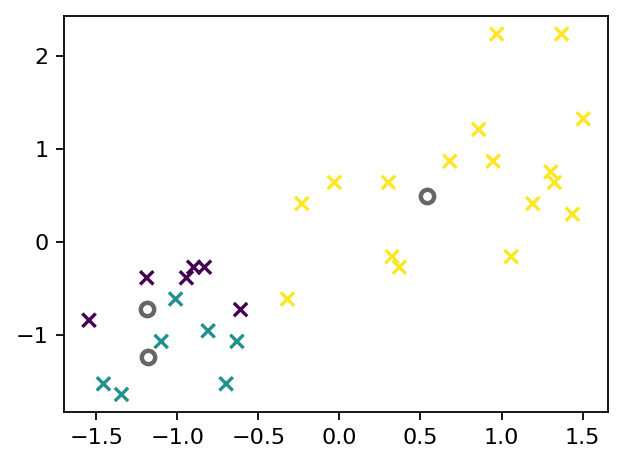

In [18]:
#예측 결과 그래프로 확인

import matplotlib.pyplot as plt

plt.figure(figsize=(4,3), dpi=160)
plt.scatter(y[:, 0], y[:, 1], c=cluster_ids_y, cmap='viridis', marker='x')

plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1],
    c='white', alpha=0.6, edgecolors='black', linewidths=2
)

plt.tight_layout()
plt.show()

2. 가우시안 혼합 모델 (GMM, Gaussian Mixture Model)

  : 가우시안 분포가 K개 혼합된 클러스터링 알고리즘 (k는 하이퍼파라미터)

In [19]:
#라이브러리 호출 및 데이터 로딩
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

x_train = np.load('/content/drive/MyDrive/pytorch_ex/chap11/data/data.npy') #파일을 배열로 불러옴

[[3.0363831  3.09828041]
 [1.60629419 1.3470999 ]]


[[[ 0.8465178   0.38644336]
  [ 0.38644336  0.73395863]]

 [[ 0.75275611 -0.5054196 ]
  [-0.5054196   0.74286061]]]


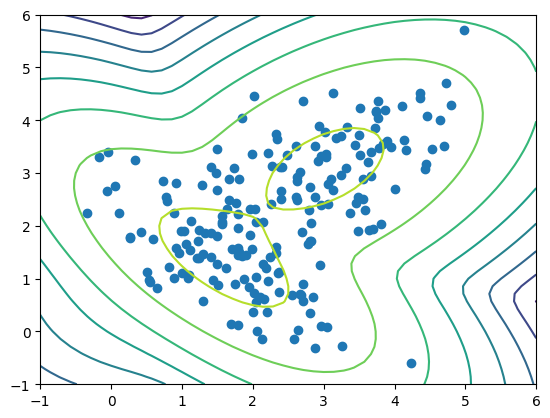

In [20]:
#GMM 생성

gmm = GaussianMixture(n_components=2)  #가우시안 개수: 2개
gmm.fit(x_train)

print(gmm.means_)
print('\n')
print(gmm.covariances_)

X, Y = np.meshgrid(np.linspace(-1,6), np.linspace(-1,6))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = gmm.score_samples(XX)
Z = Z.reshape((50, 50))

plt.contour(X, Y, Z)
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.show()

3. 자가 조직화 지도

In [22]:
pip install MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=9847d1bda6255f45773babd071174393dea01a8501f727aaad246143cf7c2d31
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built MiniSom


In [23]:
#라이브러리 호출
import numpy as np
from sklearn.datasets import load_digits
from minisom import MiniSom
from pylab import plot, axis, show, pcolor, colorbar, bone

#이미지 데이터셋 내려받기
digits = load_digits()
data = digits.data #훈련 세트
labels = digits.target #정답(레이블)

SOM 초기화

. SOM 진행 종료


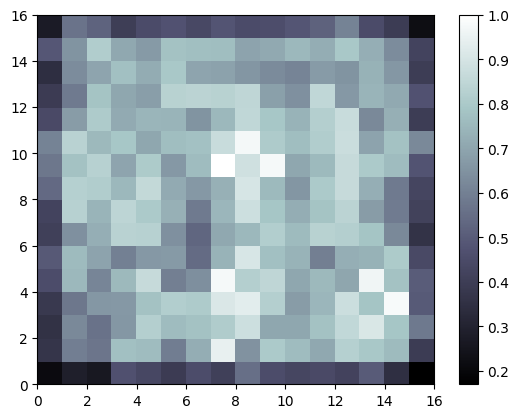

In [24]:
#훈련 세트를 minisom 알고리즘에 적용

som = MiniSom(16, 16, 64, sigma=1.0, learning_rate=0.5)
som.random_weights_init(data)
print('SOM 초기화')
som.train_random(data, 10000)
print('\n. SOM 진행 종료')

bone()
pcolor(som.distance_map().T)
colorbar()

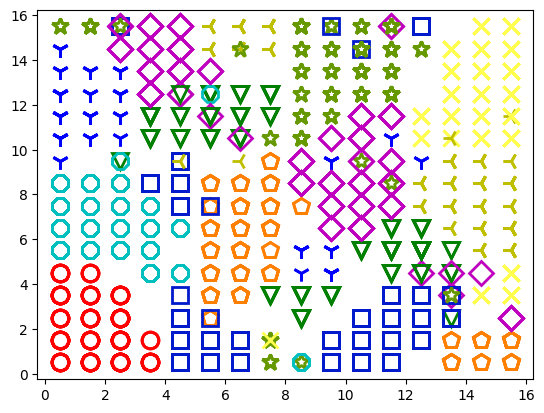

In [25]:
#클래스에 대해 레이블 설정 및 색상 할당
labels[labels == '0'] = 0
labels[labels == '1'] = 1
labels[labels == '2'] = 2
labels[labels == '3'] = 3
labels[labels == '4'] = 4
labels[labels == '5'] = 5
labels[labels == '6'] = 6
labels[labels == '7'] = 7
labels[labels == '8'] = 8
labels[labels == '9'] = 9

markers = ['o', 'v', '1', '3', '8', 's', 'p', 'x', 'D', '*']
colors = ["r", "g", "b", "y", "c", (0,0.1,0.8), (1,0.5,0), (1,1,0.3), "m", (0.4,0.6,0)]
for cnt,xx in enumerate(data):
   w = som.winner(xx)
   plot(w[0]+.5,w[1]+.5,markers[labels[cnt]],
   markerfacecolor='None', markeredgecolor=colors[labels[cnt]],
   markersize=12, markeredgewidth=2)
show()